In [29]:
import pandas as pd
import numpy as np
import random

# Seed for reproducibility
np.random.seed(10)
random.seed(10)

import copy

### for viz
import matplotlib.pyplot as plt
import seaborn as sns

### for machine learning
import sklearn
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, roc_auc_score, log_loss


In [30]:

### synthesize dataset

# Parameters
n_rows = 1100   
years = [2024, 2025]
months = list(range(1, 13))

# Categorical fields
states_expansion = ["CA", "NY", "IL", "OH"]  
states_nonexp = ["TX", "FL", "GA", "AL"]
all_states = states_expansion + states_nonexp
zip_types = ["Urban", "Suburban", "Rural"]
insurers = ["Blue Cross", "United", "Aetna", "Cigna", "Humana", "Medicare", "Medicaid", "SelfPay"]

# Helper distributions
def assign_insurance(age, income, state):
    if age >= 65:
        return "Medicare"
    if income < 20000:
        if state in states_expansion:
            return "Medicaid"
        else:
            return "SelfPay"
    if income < 35000:
        return np.random.choice(["Medicaid","SelfPay","Blue Cross","Aetna"], p=[0.4,0.3,0.2,0.1])
    if income < 70000:
        return np.random.choice(["Blue Cross","United","Aetna","Cigna","Humana"], p=[0.3,0.25,0.15,0.15,0.15])
    return np.random.choice(["Blue Cross","United","Aetna","Cigna","Humana"], p=[0.25,0.25,0.2,0.15,0.15])

def secondary_coverage(ins):
    if ins == "Medicare":
        return np.random.choice(["Yes","No"], p=[0.6,0.4])
    return "No"

def denial_reason(insurer):
    if insurer == "United":
        return np.random.choice(["Authorization","Coding","None"], p=[0.4,0.4,0.2])
    if insurer == "Blue Cross":
        return np.random.choice(["Coding","Eligibility","None"], p=[0.5,0.3,0.2])
    if insurer in ["Medicaid","SelfPay"]:
        return "None"
    return np.random.choice(["Coding","Incomplete Info","Other","None"], p=[0.3,0.2,0.2,0.3])

# Build dataset
records = []
patient_ids = range(1, 301)  # ~300 patients

for _ in range(n_rows):
    pid = random.choice(list(patient_ids))
    year = random.choice(years)
    month = random.choice(months)
    age = random.randint(1, 90)
    income = round(np.random.normal(50000, 25000), 2)
    if income < 5000: income = 5000
    state = random.choice(all_states)
    ziptype = np.random.choice(zip_types, p=[0.4,0.35,0.25])
    insurer = assign_insurance(age, income, state)
    secondary = secondary_coverage(insurer)
    visits = np.random.poisson(lam=1.5)+1
    
    billed = round(np.random.uniform(100, 20000),2)
    
    # Adjustments by payer type
    if insurer == "Medicare":
        allowed = billed * 0.5
    elif insurer == "Medicaid":
        allowed = billed * 0.3
    elif insurer == "SelfPay":
        allowed = billed * 0.8
    else:
        allowed = billed * 0.6
    patient_resp = allowed * (0.2 if insurer not in ["Medicaid","SelfPay"] else 1.0)
    insurance_pay = allowed - patient_resp if insurer not in ["SelfPay"] else 0
    
    # Actual payments based on income & assistance
    pay_prob = 0.8 if income > 40000 else 0.4
    if insurer in ["Medicaid","Medicare"]: pay_prob += 0.1
    paid_patient = patient_resp * (np.random.binomial(1,pay_prob))
    total_payments = insurance_pay + paid_patient
    balance = allowed - total_payments
    
    # Denials
    denial = np.random.binomial(visits, 0.1 if insurer not in ["SelfPay","Medicaid"] else 0.02)
    denial_reason_val = "None" if denial==0 else denial_reason(insurer)
    resub = 0 if denial==0 else np.random.choice([1,2], p=[0.8,0.2])
    
    # Targets
    likely_to_pay = True if (balance< (0.5*allowed) and income>20000) else False
    fa_eligible = True if (income<30000 or (insurer=="SelfPay" and balance>500)) else False
    
    prior_unpaid = round(balance*np.random.binomial(1,0.3),2)  # 30% chance of carrying balance
    
    records.append([pid,year,month,age,income,ziptype,state,insurer,secondary,
                    visits,prior_unpaid,round(billed,2),round(balance,2),
                    denial,denial_reason_val,resub,likely_to_pay,fa_eligible])

# Create dataframe
columns = ["PatientID","Year","Month","Age","Income","ZipType","State","InsurancePlan",
           "SecondaryCoverage","TotalVisits","PriorUnpaidBalance","Billed Amount",
           "Balance Amount","ClaimsDenied","DenialReason","Resubmissions",
           "LikelyToPay","FinancialAssistanceEligible"]
_med_df = pd.DataFrame(records, columns=columns)

## get a normalized date i.e. 1st day of each month using year and month columns
_med_df['date'] = pd.to_datetime(_med_df[['Year', 'Month']].assign(DAY=1))



In [58]:
import matplotlib.pyplot as plt
# plt.style.use('dark_background')
plt.style.use('ggplot')

In [60]:
### schema enforcement

dtype_dict = {
    'PatientID': np.uint32,
    'Year': np.uint16,
    'Month': np.uint8,
    'date': 'datetime64[ns]',
    'Age': np.uint8,
    'Income': float,

    ## category columns
    'ZipType': 'category',
    'InsurancePlan': 'category',
    'DenialReason': 'category',
    'State': 'category',

    'TotalVisits': np.uint16,
    'PriorUnpaidBalance': float,
    'Billed Amount': float,
    'Balance Amount': float,
    'ClaimsDenied': np.uint16,
    'Resubmissions': np.uint16,

    ### boolean columns
    'LikelyToPay': np.bool,
    'SecondaryCoverage': np.bool,
    'FinancialAssistanceEligible': np.bool,



}
med_df = copy.deepcopy( _med_df ).astype(dtype_dict)

### remove any space from the column names from anywhere
med_df.columns = med_df.columns.str.replace(' ', '', regex=False)
med_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   PatientID                    1100 non-null   uint32        
 1   Year                         1100 non-null   uint16        
 2   Month                        1100 non-null   uint8         
 3   Age                          1100 non-null   uint8         
 4   Income                       1100 non-null   float64       
 5   ZipType                      1100 non-null   category      
 6   State                        1100 non-null   category      
 7   InsurancePlan                1100 non-null   category      
 8   SecondaryCoverage            1100 non-null   bool          
 9   TotalVisits                  1100 non-null   uint16        
 10  PriorUnpaidBalance           1100 non-null   float64       
 11  BilledAmount                 1100 non-null 

#### `Financial Performance KPIs`

In [61]:
denial_rate = ( copy.deepcopy( med_df )
    .agg( total_claims=('TotalVisits', 'sum'), denied_claims=('ClaimsDenied', 'sum') )
    .pipe(lambda x: x['ClaimsDenied'].sum() / x['TotalVisits'].sum() * 100)
)
denial_rate

np.float64(8.07663410969196)

`Net Collection Rate`

In [62]:
### net collection rate
net_collection_df = (  copy.deepcopy( med_df )
    .assign( collected= lambda df: df['BilledAmount'] - df['BalanceAmount'] )
    .agg(  total_collected = ('collected', 'sum'),
           total_billed = ('BilledAmount', 'sum')
    )
    # .pipe(  lambda x: x['collected'].sum() / x['BilledAmount'].sum() * 100  )
)

net_collection_df

,collected,BilledAmount
total_collected,9883491.56,NaN
total_billed,NaN,10616454.94


In [63]:
### avg collection rate
avg_collection_df = (  med_df
    .assign( collected= lambda df: df['BilledAmount'] - df['BalanceAmount'] )
    .agg(  total_collected = ('collected', 'mean'),
           total_billed = ('BilledAmount', 'mean')
    )
    # .pipe(  lambda x: x['collected'].sum() / x['BilledAmount'].sum() * 100  )
)
avg_collection_df

,collected,BilledAmount
total_collected,8984.992327,NaN
total_billed,NaN,9651.322673


`Bad Debt / Write-Off %`

In [64]:
med_df = (  med_df
    ## Define conditions
    .assign(
        writeoff_unlikely = lambda df: ( ~df['LikelyToPay'] ) & ( ~df['FinancialAssistanceEligible'] ),
        writeoff_charity = lambda df: ( df['FinancialAssistanceEligible'] ),
        writeoff = 0.0
    )

    ## apply rules using above defined condition help
    .pipe(  lambda df: df.assign(
        writeoff = lambda _df: _df['writeoff']
                        ## Case 1: unlikely to pay, no assistance --> full balance written off
                        .mask( _df['writeoff_unlikely'], _df['BalanceAmount'] ) 
                        ## Case 2: assistance eligible --> 50% billed amount written off
                        .mask( _df['writeoff_charity'], _df['BalanceAmount']*0.5 )
        )
    )

    .drop(  columns = [ 'writeoff_unlikely', 'writeoff_charity' ]  )

)

## add collected field
med_df['Collected_'] = (med_df['BilledAmount'] - med_df['BalanceAmount'] - med_df['writeoff']).clip(lower=0)


total_writeoff = med_df['writeoff'].sum()
total_billed   = med_df['BilledAmount'].sum()

total_writeoff, total_billed


bad_debt_rate = total_writeoff / total_billed * 100
bad_debt_rate

np.float64(2.4866137189105797)

`First-Pass Resolution Rate`

percentage of claims paid on the first submission without needing any resubmission or appeal.

In [65]:
# 5. First-Pass Resolution Rate (claims without resubmissions)
df = copy.deepcopy( med_df )
first_pass_res_rate = ( (df['TotalVisits'].sum() - df['Resubmissions'].sum()) 
                        / df['TotalVisits'].sum() * 100 )

# 5. First-Pass Resolution Rate (claims without resubmissions)
first_pass_res_rate = ( (df['TotalVisits'].sum() - df['Resubmissions'].sum()) 
                        / df['TotalVisits'].sum() * 100 )

In [66]:
first_pass_rate = ( med_df
    .agg(total_claims=('TotalVisits', 'sum'), denied_claims=('ClaimsDenied', 'sum'))
    # .pipe(lambda x: (x['TotalVisits'].sum() - x['ClaimsDenied'].sum() ) / x['TotalVisits'].sum() * 100)
)


first_pass_rate
first_pass_rate.pipe(lambda x: (x['TotalVisits'].sum() - x['ClaimsDenied'].sum() ) / x['TotalVisits'].sum() * 100)

np.float64(91.92336589030803)

`Cost-to-Collect`

measures how much it costs to collect revenue, expressed as a percentage of the amount collected. Cost to Collect = (Total Revenue Cycle Costs / Total Collections) × 100%


In [67]:
cost_to_collect_pct = (  med_df
    .assign(
          collected=lambda d: d['BilledAmount'] - d['BalanceAmount'],
          cost_to_collect=lambda d: d['TotalVisits'] * 65  # $5 cost per visit/claim
      )
      .agg(total_cost=('cost_to_collect', 'sum'), total_collected=('collected', 'sum'))
    #   .pipe(lambda x: x['cost_to_collect'].sum() / x['collected'].sum() * 100)
)

print( cost_to_collect_pct )
round( cost_to_collect_pct.pipe(lambda x: x['cost_to_collect'].sum() / x['collected'].sum() * 100), 2)

                 cost_to_collect   collected
total_cost              173030.0         NaN
total_collected              NaN  9883491.56


np.float64(1.75)

`Client Value / Business Impact KPIs`

Revenue Recovery Uplift: measures the extra revenue collected due to the analytics or interventions (Analytics impact), compared to what would have been collected without those tools.

In [68]:
 ## assuming these patients would not have paid without intervention but were recovered
revenue_uplift = ( med_df
    .assign( collected= lambda d: d['BilledAmount'] - d['BalanceAmount'] )
    .query( 'LikelyToPay == False') 
    ['collected'].sum()
)
print(revenue_uplift)
### assuming Client paid $57 per patient claim for BI service (just using random number for sake of calculation)
cost_of_bi = med_df.shape[0]*57

## Revenue Recovery Uplift ratio

revenue_uplift_ratio = round( revenue_uplift/cost_of_bi , 1)
# revenue_uplift_ratio = round( revenue_uplift/57 , 1)
revenue_uplift_ratio

1214540.0799999998


np.float64(19.4)

In [69]:
revenue_uplift_df = ( med_df
    .assign( collected= lambda d: d['BilledAmount'] - d['BalanceAmount'] )
    .query( 'LikelyToPay == False').reset_index(drop=True)
    .assign( collect_ratio = lambda df: round( df['collected']/df['BilledAmount'], 3 ) )
)
revenue_uplift_df

,PatientID,Year,Month,Age,Income,ZipType,State,InsurancePlan,SecondaryCoverage,TotalVisits,...,ClaimsDenied,DenialReason,Resubmissions,LikelyToPay,FinancialAssistanceEligible,date,writeoff,Collected_,collected,collect_ratio
0,18,2025,6,10,34143.65,Suburban,OH,SelfPay,True,3,...,0,None,0,False,True,2025-06-01,6449.575,0.000,3224.79,0.2
1,224,2025,2,84,14673.30,Suburban,FL,Medicare,True,2,...,0,None,0,False,True,2025-02-01,978.925,16641.725,17620.65,0.9
2,257,2024,4,53,5000.00,Suburban,OH,Medicaid,True,3,...,0,None,0,False,True,2024-04-01,0.000,9344.160,9344.16,1.0
3,126,2025,3,80,16988.81,Suburban,IL,Medicare,True,3,...,0,None,0,False,True,2025-03-01,442.405,7520.925,7963.33,0.9
4,170,2025,4,11,17635.26,Suburban,TX,SelfPay,True,1,...,0,None,0,False,True,2025-04-01,2735.885,0.000,1367.94,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,220,2024,10,40,23903.66,Rural,NY,SelfPay,True,5,...,1,None,1,False,True,2024-10-01,262.680,0.000,131.34,0.2
166,135,2025,8,38,24875.01,Suburban,IL,SelfPay,True,2,...,0,None,0,False,True,2025-08-01,2490.165,0.000,1245.08,0.2
167,226,2024,11,27,26220.73,Urban,IL,Medicaid,True,1,...,0,None,0,False,True,2024-11-01,1991.285,7301.395,9292.68,0.7
168,288,2024,9,71,16897.46,Urban,TX,Medicare,True,2,...,0,None,0,False,True,2024-09-01,0.000,15639.080,15639.08,1.0


Client ROI on BI Solutions

Return on Investment for the client using BI tools, essentially how much benefit (revenue uplift) they get for the cost they pay for the solution. 

In [70]:
### assuming Client paid $57 per patient claim for BI service (just using random number for sake of calculation)
cost_of_bi = med_df.shape[0]*57
round( revenue_uplift/cost_of_bi , 1)

np.float64(19.4)

##### develop ML model

In [71]:
drop_cols = ['PatientID', 'date', 'writeoff', 'FinancialAssistanceEligible']
med_ml_df = med_df.drop( columns= drop_cols )
med_ml_df

## target var ( convert bool to int)
med_ml_df['LikelyToPay'] = med_ml_df['LikelyToPay'].astype(int)

X = med_ml_df.drop("LikelyToPay", axis=1)
y = med_ml_df["LikelyToPay"]

In [72]:
## Preprocessing

## Categorical & numeric split
cat_features = [  'ZipType','InsurancePlan','DenialReason','State'  ]
num_features = [  col for col in X.columns if col not in cat_features  ]


# One-hot encode categoricals
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = ohe.fit_transform(X[cat_features])
cat_names = ohe.get_feature_names_out(cat_features)

# Scale numerics
scaler = StandardScaler()
X_num = scaler.fit_transform(X[num_features])

# Final feature matrix
X_all = np.hstack([X_cat, X_num])
feature_names = np.concatenate([cat_names, num_features])

In [73]:
def auc_scorer(y_true, y_pred):
    # clip linear reg outputs to [0,1] for prob  interpretation
    return roc_auc_score(y_true, np.clip(y_pred,0,1))

def logloss_scorer(y_true, y_pred):
    return -log_loss(y_true, np.clip(y_pred,1e-6,1-1e-6))


scoring = {
    'AUC': make_scorer(auc_scorer, greater_is_better=True),
    'LogLoss': make_scorer(logloss_scorer, greater_is_better=True)
}

In [74]:
#### validation
cross_vald = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [75]:
lin_model = LinearRegression()
lin_results = cross_validate(lin_model, X_all, y, cv= cross_vald, scoring=scoring )


In [76]:
# Random Forest
# -----------------------
rf_model = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=10)
rf_results = cross_validate( rf_model, X_all, y, cv=cross_vald, scoring=scoring )

In [77]:
# Compare Results
print("Linear Regression - AUC:", lin_results['test_AUC'].mean(), "LogLoss:", -lin_results['test_LogLoss'].mean())
print("Random Forest   - AUC:", rf_results['test_AUC'].mean(), "LogLoss:", -rf_results['test_LogLoss'].mean())


Linear Regression - AUC: 0.9860531309297913 LogLoss: 0.1539677182554094
Random Forest   - AUC: 0.9992884250474383 LogLoss: 0.019650217132220413


In [78]:
lin_model.fit(X_all,y)
rf_model.fit(X_all,y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [79]:
 ## Linear Regression coeff
_coef_df = (
    pd.DataFrame(  { 'Feature': feature_names, 'Coefficient': lin_model.coef_ }  )
      .sort_values( by='Coefficient', key= lambda s: s.abs(), ascending= False, ignore_index= True )
    .assign(  
        coeff_pos = lambda df: abs(df['Coefficient']),
      )
    .pipe(  lambda df:
        df[ df['Feature'].str.contains('DenialReason') ]
    )
    
    .assign(   denial_feature = lambda df: df['Feature'].str.replace('DenialReason_','', regex=False  )   )
    ## remove the row with nan from denial_feature column
    .query( 'denial_feature != "nan"' )
    ## calc percentage of each coeff from total coeff sum
    .assign( coeff_pct = lambda df: round(  df['Coefficient'].div( df['coeff_pos'].sum() ).mul(100), 1 )  )

    .sort_values( 'coeff_pos', ascending= False, ignore_index= True )



      
)
_coef_df

,Feature,Coefficient,coeff_pos,denial_feature,coeff_pct
0,DenialReason_Incomplete Info,-0.147992,0.147992,Incomplete Info,-45.9
1,DenialReason_Other,0.062559,0.062559,Other,19.4
2,DenialReason_Authorization,0.055567,0.055567,Authorization,17.2
3,DenialReason_Eligibility,0.031951,0.031951,Eligibility,9.9
4,DenialReason_Coding,-0.013196,0.013196,Coding,-4.1
5,DenialReason_None,0.011111,0.011111,None,3.4


In [80]:
## Linear Regression coeff
coef_df = (
    pd.DataFrame(  { 'Feature': feature_names, 'Coefficient': lin_model.coef_ }  )
      .sort_values( by='Coefficient', key= lambda s: s.abs(), ascending= False, ignore_index= True )
    .assign(  
        coeff_pos = lambda df: abs(df['Coefficient']),
        feature_broad = lambda df: df['Feature'].apply(  lambda _df: _df.split('_')[0]  )
      )
    ###  average the abs coeff to calculate broader effect
    .groupby( 'feature_broad' )[['coeff_pos']].mean().reset_index().sort_values( 'coeff_pos', ascending= False, ignore_index= True )
    ## find the relative percentage of the effect of coeff
    .assign(
        coeff_pct = lambda df: round(  df['coeff_pos'].div( df['coeff_pos'].sum() ).mul(100), 1 )
    )
      
)
coef_df

,feature_broad,coeff_pos,coeff_pct
0,Collected,1.005106e+00,36.7
1,BilledAmount,1.000541e+00,36.5
2,BalanceAmount,3.518751e-01,12.8
3,InsurancePlan,1.751855e-01,6.4
4,Income,1.030485e-01,3.8
5,DenialReason,5.372921e-02,2.0
6,State,1.406952e-02,0.5
7,TotalVisits,9.663099e-03,0.4
8,ZipType,6.822978e-03,0.2
9,Year,6.290784e-03,0.2


In [81]:
# coef_df.to_csv( r'viz_dataset\coeff.csv', index= False )
# _coef_df.to_csv( r'viz_dataset\coeff_denial.csv', index= False )


<Axes: xlabel='coeff_pct', ylabel='feature_broad'>

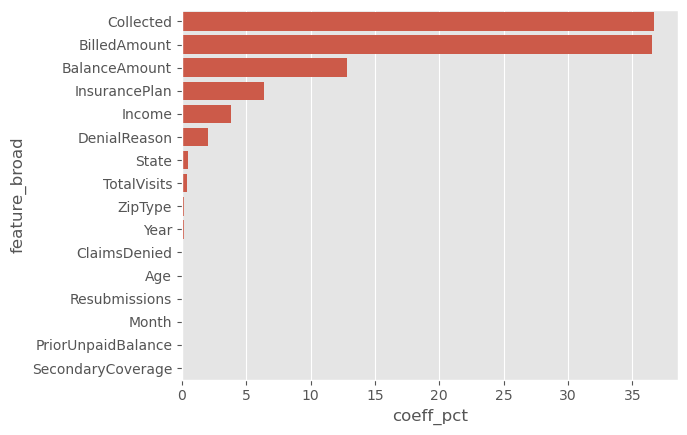

In [82]:
sns.barplot( data= coef_df, x= 'coeff_pct', y= 'feature_broad' )

<Axes: xlabel='coeff_pct', ylabel='Feature'>

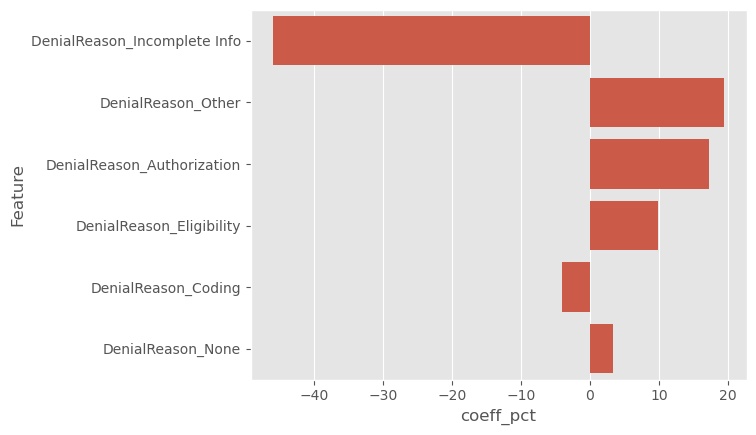

In [83]:
sns.barplot( data= _coef_df, x= 'coeff_pct', y= 'Feature' )


In [84]:
# --- Random Forest Importances ---
imp_df = (
    pd.DataFrame({'Feature': feature_names, 'Importance': rf_model.feature_importances_})
      .sort_values(by='Importance', ascending=False)
      .head(15)
)

imp_df

,Feature,Importance
28,Income,0.701730
33,BalanceAmount,0.247088
7,InsurancePlan_Medicaid,0.033442
36,Collected_,0.014383
8,InsurancePlan_Medicare,0.000721
4,InsurancePlan_Blue Cross,0.000688
32,BilledAmount,0.000579
22,State_NY,0.000546
26,Month,0.000300
27,Age,0.000202


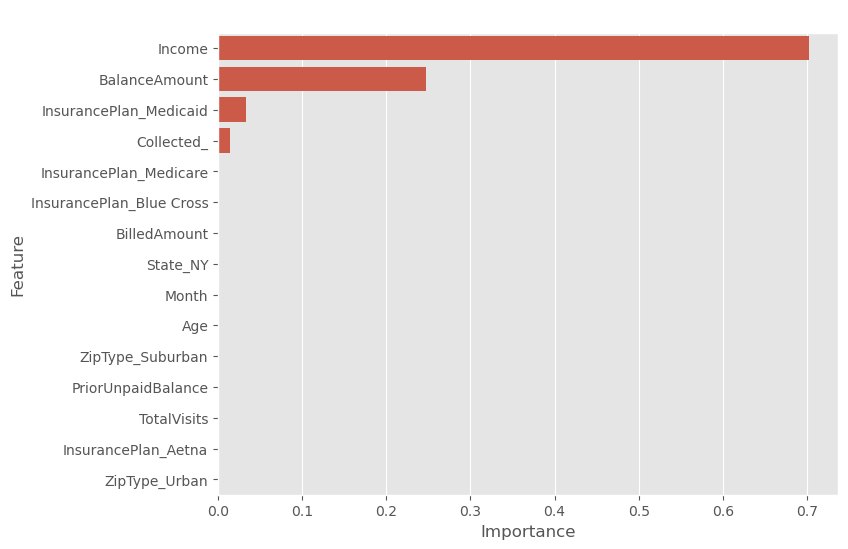

In [85]:

plt.figure(figsize=(8,6))
sns.barplot(data=imp_df, x='Importance', y='Feature')
plt.title("Random Forest Top Feature Importances")
plt.show()